In [1]:
%load_ext autoreload
%autoreload 2

This notebook was used to create Figures 4 and 5 from the paper (the Titanic plots).

Note that you will have to install the python module `TreeModelsFromScratch`, directions for which can be found on the [original github page](https://github.com/Heity94/AugmentedHierarchicalShrinkage).

In [2]:
#Import Tree Models from scratch functions
# import sys
# import os

# module_path = os.path.abspath(os.path.join('..'))+"/TreeModelsFromScratch"
# if module_path not in sys.path:
#     sys.path.append(module_path)

from TreeModelsFromScratch.DecisionTree import DecisionTree
from TreeModelsFromScratch.RandomForest import RandomForest
from TreeModelsFromScratch.SmoothShap import smooth_shap, GridSearchCV_scratch, cross_val_score_scratch

In [8]:
# Import other packages
import shap
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
import numbers
from tqdm import trange
import matplotlib as mpl
import os

In [4]:
# Gloabl figure settings
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

In [5]:
#load JS vis in the notebook for shap plots
shap.initjs() 

# Titanic

In [9]:
data_path = os.path.join(os.path.dirname(os.getcwd()),"data","titanic")

### Load and clean data

In [10]:
# Load data 
data = pd.read_csv("../raw_data/titanic/titanic_train.csv")
data = data[data["Age"].notnull()] #filter rows which are nan
data["Sex"] = pd.get_dummies(data["Sex"])["female"] #dummy code sex (1==Female)

In [11]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",1,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",0,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",0,26.0,0,0,111369,30.0000,C148,C


In [ ]:
# Create X and y
X = data[['Age', 'Pclass', 'Sex', 'PassengerId']]
y = data["Survived"].astype("float")

In [ ]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=42)

### Train RF model

Relevant arguments for the `RandomForest` function:
- `n_tress`: int, default=10
    - Number of trees in the ensemble
- `treetype` str {"classification", "regression}, default="classification"
    - Model type
- `oob_SHAP` bool, default=False
    - If inbag and oob SHAP values should be computed during fit and stored as class attributes
    - SHAP inbag will be stored under `model.inbag_SHAP_values`
    - SHAP oob will be stored under `model.oob_SHAP_values`
- `max_depth` int, default=None
- `min_samples_split`: int, default=2
- `min_samples_leaf`: int, default=1,
- `n_feature`: {"sqrt"} or int, default="sqrt"
    - Similar to sklearn`s `max_features`
    - If int, then consider `n_feature` features at each split
    - If “sqrt”, then `max_features=sqrt(n_features)`

In [10]:
# Fit regular RF model 
rf = RandomForest(n_trees=100, treetype='classification', oob_SHAP=True, random_state=42)
rf.fit(X_train, y_train)

In [11]:
# ROC AUC score on test set
y_pred = rf.predict(X_test)
roc_auc_score(y_test, y_pred)

0.7920902443374354

### Compute SHAP values

The class function `model.export_forest_for_SHAP()`creates anoutput which is readable by SHAP. <br>
To import the RF for a Single Decision Tree the class function is called `model.export_tree_for_SHAP()`.

In [12]:
# Raw SHAP values of RF model 
export_model_rf = rf.export_forest_for_SHAP() 
explainer_rf = shap.TreeExplainer(export_model_rf)
shap_vals_rf_raw = explainer_rf.shap_values(X_train, y_train)

In [13]:
# The inbag and oob SHAP values are stored as class attributes of the RF model object
rf.inbag_SHAP_values # Inbag SHAP values
rf.oob_SHAP_values # OOB SHAP values

array([[-0.02159054, -0.07094237, -0.19103283, -0.06940424],
       [ 0.12524321,  0.09306224,  0.32191429, -0.04829458],
       [ 0.03781554, -0.0807783 , -0.15097095, -0.01945284],
       ...,
       [-0.00772972,  0.24817447,  0.34618808,  0.01056329],
       [-0.03057773, -0.14714212, -0.11871147, -0.0035749 ],
       [-0.00592465, -0.07220626, -0.16254208,  0.03937141]])

In [14]:
# Compute smooth SHAP values
smshap_vals, abs_mean_smshap, coefs_smshap = smooth_shap(rf.inbag_SHAP_values, rf.oob_SHAP_values)

In [14]:
# Smooth SHAP coefficient for each feature
pd.DataFrame(np.array([coefs_smshap]), columns=X_train.columns)

,Age,Pclass,Sex,PassengerId
0,0.61567,0.923729,0.983575,0.102725


In [17]:
import pickle 
#Create dict and pickle data
shap_data = {
    "X_train": X_train,
    "y_train": y_train,
    "SHAP_raw": shap_vals_rf_raw,
    "SHAP_inbag": rf.inbag_SHAP_values, 
    "SHAP_oob": rf.oob_SHAP_values,
    "SHAP_smooth": smshap_vals,
    "coef_smSHAP": coefs_smshap
}

with open(f'{data_path}/titanic_SHAP_dict.pickle', 'wb') as handle:
    pickle.dump(shap_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Examine Smooth SHAP coefficients

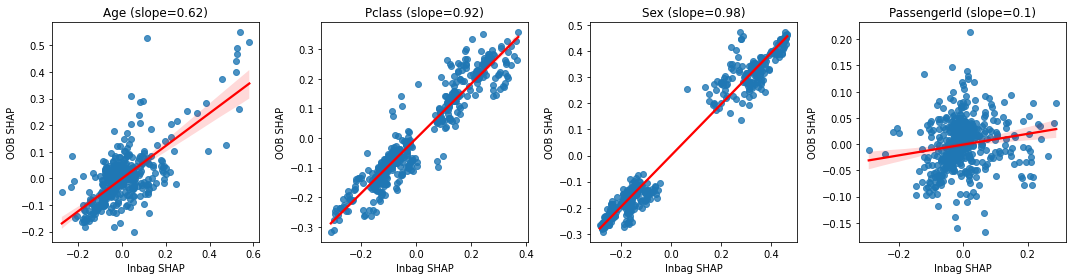

In [46]:
fig, axs = plt.subplots(1,4, figsize=(15,4))

for i in range(4):
    p = sns.regplot(x=rf.inbag_SHAP_values[:, i].reshape(-1, 1), y=rf.oob_SHAP_values[:, i], line_kws={"color": "red"}, ax=axs[i])
    slope, intercept, r_value, p_value, std_err = linregress(x=p.get_lines()[0].get_xdata(),y=p.get_lines()[0].get_ydata())
    axs[i].set_title(f"{rf.feature_names[i]} (slope={round(slope,2)})")# - regression coef: {np.round(rf_scr.smSHAP_coefs[i],2)}")
    axs[i].set_xlabel("Inbag SHAP")
    axs[i].set_ylabel("OOB SHAP")

#plt.setp(axs, xlim=[0, 0.5], ylim=[0, 0.5]);
plt.tight_layout();

### Examine distribution of absolute SHAP values 

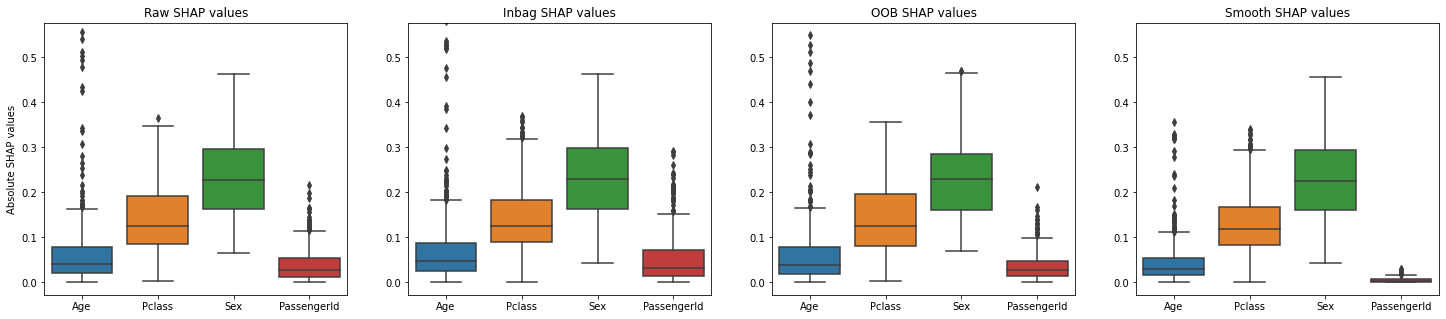

In [15]:
#Create boxplots
fig, axs = plt.subplots(1,4,figsize=(25,5))

sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs[0])
sns.boxplot(data=np.abs(rf.inbag_SHAP_values), ax=axs[1])
sns.boxplot(data=np.abs(rf.oob_SHAP_values), ax=axs[2])
sns.boxplot(data=np.abs(smshap_vals), ax=axs[3])

axs[0].set_ylabel("Absolute SHAP values")
axs[0].set_title("Raw SHAP values")
axs[1].set_title("Inbag SHAP values")
axs[2].set_title("OOB SHAP values")
axs[3].set_title("Smooth SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns)

plt.setp(axs, ylim=axs[2].get_ylim());

#### Create and save single plots for Markus

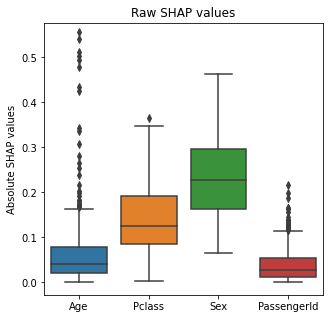

In [16]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs)
#sns.boxplot(data=np.abs(rf.inbag_SHAP_values), ax=axs[1])
#sns.boxplot(data=np.abs(rf.oob_SHAP_values), ax=axs[2])
#sns.boxplot(data=np.abs(smshap_vals), ax=axs[3])

axs.set_ylabel("Absolute SHAP values")
axs.set_title("Raw SHAP values")
#axs[1].set_title("Inbag SHAP values")
#axs[2].set_title("OOB SHAP values")
#axs[3].set_title("Smooth SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns)

plt.setp(axs, ylim=(-0.027440041920040608, 0.5763508585288003));

fig.savefig(data_path+"/titanic_shap_boxplot_raw.pdf")

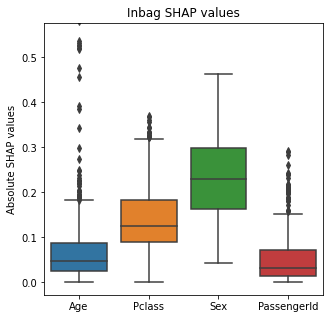

In [34]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

#sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs)
sns.boxplot(data=np.abs(rf.inbag_SHAP_values), ax=axs)
#sns.boxplot(data=np.abs(rf.oob_SHAP_values), ax=axs)
#sns.boxplot(data=np.abs(smshap_vals), ax=axs)

axs.set_ylabel("Absolute SHAP values")
#axs.set_title("Raw SHAP values")
axs.set_title("Inbag SHAP values")
#axs.set_title("OOB SHAP values")
#axs.set_title("Smooth SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns)

plt.setp(axs, ylim=(-0.027440041920040608, 0.5763508585288003));

fig.savefig(data_path+"/titanic_shap_boxplot_inbag.pdf")

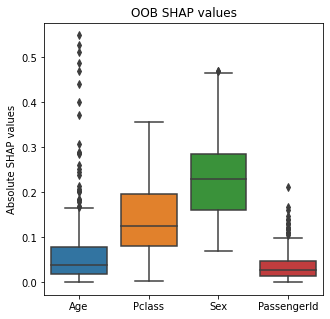

In [35]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

#sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs)
#sns.boxplot(data=np.abs(rf.inbag_SHAP_values), ax=axs)
sns.boxplot(data=np.abs(rf.oob_SHAP_values), ax=axs)
#sns.boxplot(data=np.abs(smshap_vals), ax=axs)

axs.set_ylabel("Absolute SHAP values")
#axs.set_title("Raw SHAP values")
#axs.set_title("Inbag SHAP values")
axs.set_title("OOB SHAP values")
#axs.set_title("Smooth SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns)

plt.setp(axs, ylim=(-0.027440041920040608, 0.5763508585288003));

fig.savefig(data_path+"/titanic_shap_boxplot_oob.pdf")

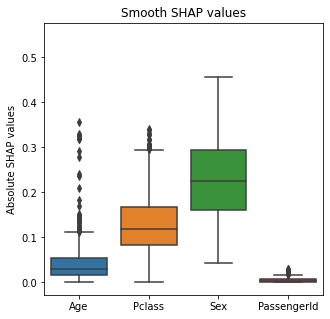

In [36]:
#Create boxplots
fig, axs = plt.subplots(1,1,figsize=(5,5))

#sns.boxplot(data=np.abs(shap_vals_rf_raw), ax =axs)
#sns.boxplot(data=np.abs(rf.inbag_SHAP_values), ax=axs)
#sns.boxplot(data=np.abs(rf.oob_SHAP_values), ax=axs)
sns.boxplot(data=np.abs(smshap_vals), ax=axs)

axs.set_ylabel("Absolute SHAP values")
#axs.set_title("Raw SHAP values")
#axs.set_title("Inbag SHAP values")
#axs.set_title("OOB SHAP values")
axs.set_title("Smooth SHAP values")

plt.setp(axs, xticks=[0, 1, 2, 3], xticklabels=X_train.columns)

plt.setp(axs, ylim=(-0.027440041920040608, 0.5763508585288003));

fig.savefig(data_path+"/titanic_shap_boxplot_smooth.pdf")

### Create SHAP beeswarmplots (global explanations)

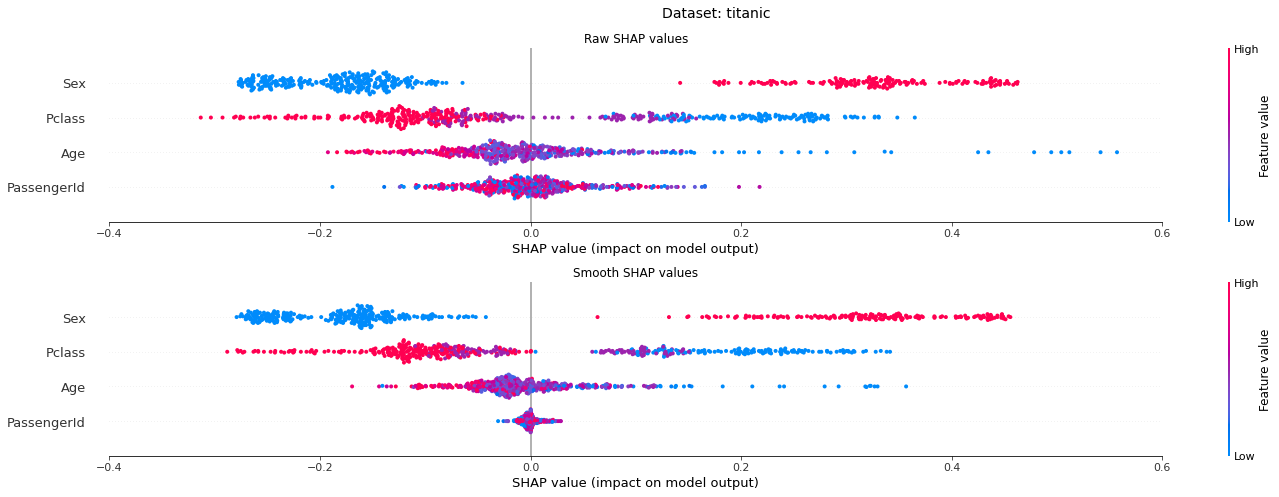

In [37]:
#Create SHAP beeswarm plots for raw SHAP and Smooth SHAP
fig = plt.figure()

#Raw SHAP vaues
ax0 = fig.add_subplot(211)
ax0.set_title("Raw SHAP values")
shap.summary_plot(shap_vals_rf_raw, X_train, X_train.columns, show=False)

#Smooth SHAP values
ax1 = fig.add_subplot(212)
ax1.set_title("Smooth SHAP values")
shap.summary_plot(smshap_vals, X_train, X_train.columns, show=False)

plt.gcf().set_size_inches(20,7)
plt.suptitle(f"Dataset: titanic", fontsize=14)
plt.setp([ax0, ax1], xlim=(-0.4, 0.6)) # set axis range for both plots
plt.tight_layout() 
plt.show()

fig.savefig(data_path+"/titanic_beeswarmplot_raw_smooth.pdf")


#### Create and save single plots for Markus

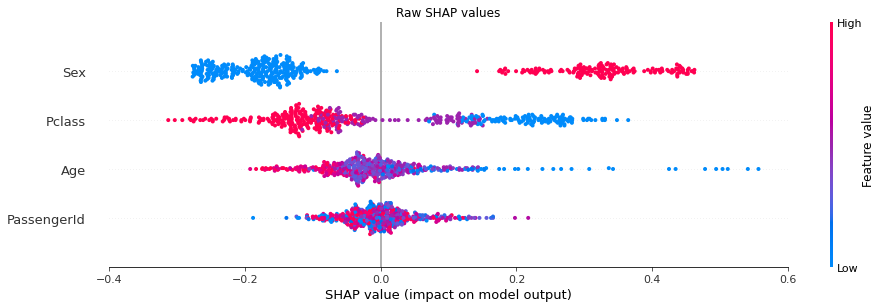

In [40]:
#Create SHAP beeswarm plots for raw SHAP and Smooth SHAP
fig = plt.figure()

#Raw SHAP vaues
ax0 = fig.add_subplot(111)
ax0.set_title("Raw SHAP values")
shap.summary_plot(shap_vals_rf_raw, X_train, X_train.columns, show=False)

# #Smooth SHAP values
# ax1 = fig.add_subplot(212)
# ax1.set_title("Smooth SHAP values")
# shap.summary_plot(smshap_vals, X_train, X_train.columns, show=False)

plt.gcf().set_size_inches(15,5)
# plt.suptitle(f"Dataset: titanic", fontsize=14)
plt.setp(ax0, xlim=(-0.4, 0.6)) # set axis range for both plots
# plt.tight_layout() 
plt.show()

fig.savefig(data_path+"/titanic_beeswarmplot_raw.pdf")


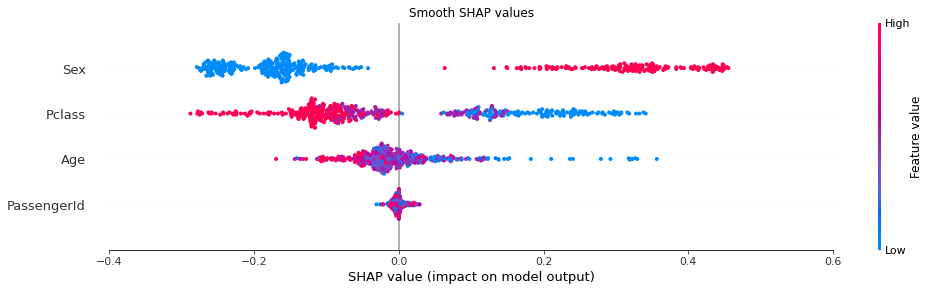

In [45]:
#Create SHAP beeswarm plots for raw SHAP and Smooth SHAP
fig = plt.figure()

#Raw SHAP vaues
# ax0 = fig.add_subplot(111)
# ax0.set_title("Raw SHAP values")
# shap.summary_plot(shap_vals_rf_raw, X_train, X_train.columns, show=False)

#Smooth SHAP values
ax1 = fig.add_subplot(212)
ax1.set_title("Smooth SHAP values")
shap.summary_plot(smshap_vals, X_train, X_train.columns, show=False)

plt.gcf().set_size_inches(16,10)
# plt.suptitle(f"Dataset: titanic", fontsize=14)
plt.setp(ax1, xlim=(-0.4, 0.6)) # set axis range for both plots
# plt.tight_layout() 
plt.show()

fig.savefig(data_path+"/titanic_beeswarmplot_smooth.pdf")


### Identify observation with high raw SHAP value for PID, but low smooth SHAP value for PID

In [18]:
# Lets create a dataframe with SHAP raw PID and SHAP smooth PID
shap_raw_pid = shap_vals_rf_raw[:,3].reshape(-1,1) # raw SHAP fo PassengerID
sm_shap_pid = smshap_vals[:,3].reshape(-1,1) # Smooth SHAP fo PassengerID

df = pd.DataFrame(np.hstack((shap_raw_pid, sm_shap_pid)), columns=["shap_raw_pid", "sm_shap_pid"])

# Create additional columns to compare differences
df["diff"] = df["shap_raw_pid"]-df["sm_shap_pid"] 
df["diff_abs"] = df["shap_raw_pid"].abs()-df["sm_shap_pid"].abs()
df.head(3)

,shap_raw_pid,sm_shap_pid,diff,diff_abs
0,-0.050766,-0.004859,-0.045907,0.045907
1,-0.037505,-0.003656,-0.033849,0.033849
2,-0.038405,-0.006282,-0.032123,0.032123


In [19]:
# Row with absolute maximum difference between SHAP raw and SHAP smooth
max_idx = df["diff_abs"].idxmax()
df.iloc[[max_idx]]

,shap_raw_pid,sm_shap_pid,diff,diff_abs
387,0.217434,0.02879,0.188644,0.188644


In [20]:
# Row with maximum negatic difference between SHAP raw and SHAP smooth
max_neg_idx = df["diff"].idxmin()
df.iloc[[max_neg_idx]]

,shap_raw_pid,sm_shap_pid,diff,diff_abs
390,-0.188235,-0.030892,-0.157343,0.157343


### Create SHAP force plots (local explanations)

#### Observation with max absolute difference

In [26]:
# Raw SHAP values for observation
shap.force_plot(explainer_rf.expected_value, shap_vals_rf_raw[max_idx,:], features=X_train.iloc[max_idx])

In [22]:
shap.save_html('explainer_roaw1.html', shap.force_plot(explainer_rf.expected_value, shap_vals_rf_raw[max_idx,:], features=X_train.iloc[max_idx]))

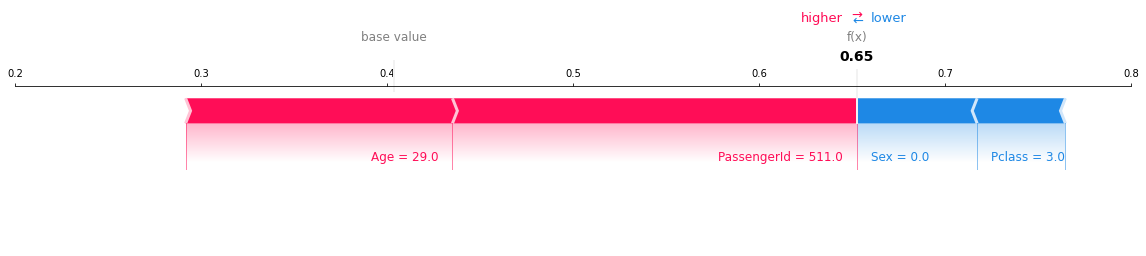

In [23]:
# Raw SHAP values for observation
shap.force_plot(explainer_rf.expected_value, shap_vals_rf_raw[max_idx,:], features=X_train.iloc[max_idx], matplotlib=True, show=False)
fig = plt.gcf()
#plt.setp(plt.gca(), xlim=(0.2, 0.8)) # set axis range for both plots
fig.savefig(data_path+"/titanic_forceplot_raw.png", pad_inches=15)
plt.show();

To preserve local accuracy we rescale the smooth SHAP values before plotting

In [52]:
df_test = pd.DataFrame(np.vstack([X_train.iloc[max_idx], shap_vals_rf_raw[max_idx,:], rf.inbag_SHAP_values[max_idx,:], coefs_smshap, smshap_vals[max_idx,:], smshap_vals[max_idx,:]*rescale_fac]), columns=X.columns)
df_test.index = ["Observation", "Raw SHAP values", "Inbag SHAP values", "Coefficients Smooth SHAP", "Smooth SHAP values", "Smooth SHAP values rescaled"]
df_test

,Age,Pclass,Sex,PassengerId
Observation,29.000000,3.000000,0.000000,511.000000
Raw SHAP values,0.143460,-0.047455,-0.064661,0.217434
Inbag SHAP values,0.184062,-0.024705,-0.042995,0.288712
Coefficients Smooth SHAP,0.615670,0.923729,0.983575,0.102725
Smooth SHAP values,0.112112,-0.023989,-0.042514,0.028790
Smooth SHAP values rescaled,0.374884,-0.080216,-0.142159,0.096269


In [27]:
# Smooth SHAP values for observation (rescaled)
rescale_fac = np.sum(shap_vals_rf_raw[max_idx,:])/np.sum(smshap_vals[max_idx,:])
shap.force_plot(explainer_rf.expected_value, smshap_vals[max_idx,:]*rescale_fac, features=X_train.iloc[max_idx])

In [84]:
shap.save_html('explainer_smo1.html', shap.force_plot(explainer_rf.expected_value, smshap_vals[max_idx,:]*rescale_fac, features=X_train.iloc[max_idx]))

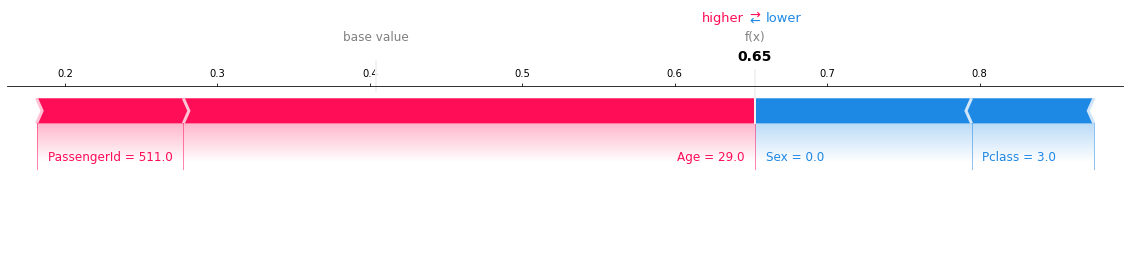

In [74]:
# Smooth SHAP values for observation (rescaled)
rescale_fac = np.sum(shap_vals_rf_raw[max_idx,:])/np.sum(smshap_vals[max_idx,:])
shap.force_plot(explainer_rf.expected_value, smshap_vals[max_idx,:]*rescale_fac, features=X_train.iloc[max_idx], matplotlib=True, show=False)
#fig = plt.gcf()
#fig.savefig(data_path+"/titanic_forceplot_smooth.png", pad_inches=15)
plt.show();

####

#### Observation with max negative difference

In [29]:
# Raw SHAP values for observation
shap.force_plot(explainer_rf.expected_value, shap_vals_rf_raw[max_neg_idx,:], features=X_train.iloc[max_neg_idx])

In [82]:
shap.save_html('explainer_raw1.html', shap.force_plot(explainer_rf.expected_value, shap_vals_rf_raw[max_neg_idx,:], features=X_train.iloc[max_neg_idx]))

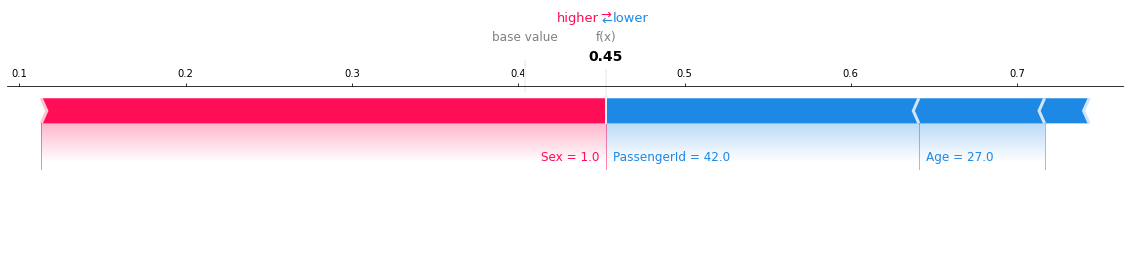

In [75]:
# Raw SHAP values for observation
shap.force_plot(explainer_rf.expected_value, shap_vals_rf_raw[max_neg_idx,:], features=X_train.iloc[max_neg_idx], matplotlib=True, show=False)
#fig = plt.gcf()
#fig.savefig(data_path+"/titanic_forceplot_smooth.png", pad_inches=15)
plt.show();

In [80]:
shap.save_html('explainer_raw.html', shap.force_plot(explainer_rf.expected_value, shap_vals_rf_raw[max_neg_idx,:], features=X_train.iloc[max_neg_idx]))

In [81]:
# Smooth SHAP values for observation (rescaled)
rescale_fac = np.sum(shap_vals_rf_raw[max_neg_idx,:])/np.sum(smshap_vals[max_neg_idx,:])
shap.force_plot(explainer_rf.expected_value, smshap_vals[max_neg_idx,:]*rescale_fac, features=X_train.iloc[max_neg_idx])

In [79]:
shap.save_html('explainer.html', shap.force_plot(explainer_rf.expected_value, smshap_vals[max_neg_idx,:]*rescale_fac, features=X_train.iloc[max_neg_idx]))

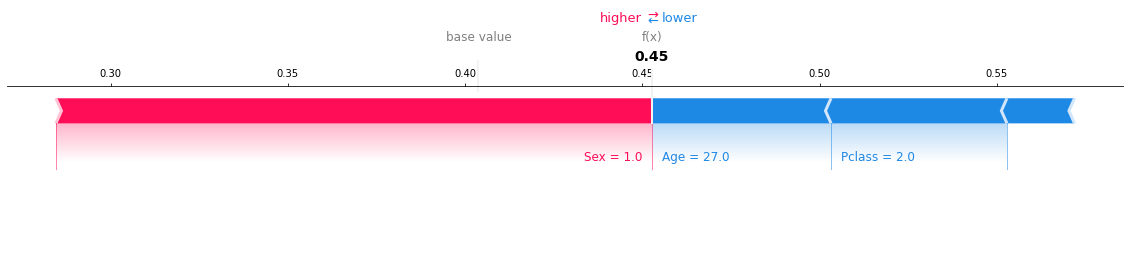

In [78]:
# Smooth SHAP values for observation (rescaled)
rescale_fac = np.sum(shap_vals_rf_raw[max_neg_idx,:])/np.sum(smshap_vals[max_neg_idx,:])
shap.force_plot(explainer_rf.expected_value, smshap_vals[max_neg_idx,:]*rescale_fac, features=X_train.iloc[max_neg_idx], matplotlib=True, show=False)
#fig = plt.gcf()
#fig.savefig(data_path+"/titanic_forceplot_smooth.png", pad_inches=15)
plt.show();

# Strobl

In [88]:
def simulate_data_strobl(n=120, # number of rows in data
                         M=100, # number of simulations
                         relevance = 0.15, # signal srength (0 for NULL)
                         seed=None):
  
    if isinstance(seed, numbers.Integral) or (seed is None):
        random_state = np.random.RandomState(seed)
    elif isinstance(seed, np.random.RandomState):
        random_state = seed

    x1 = random_state.standard_normal(size=(n,M))
    x2 = random_state.randint(1, 3, size=(n,M))
    x3 = random_state.randint(1, 5, size=(n,M))
    x4 = random_state.randint(1, 11, size=(n,M))
    x5 = random_state.randint(1, 21, size=(n,M))
    X = np.array([x1,x2,x3,x4,x5]).T
      
    y = random_state.binomial(n = 1, p = (0.5 + np.array([-1,1])[x2-1]* relevance))

    return X, y

In [89]:
#Null simulation
X_nulls, y_nulls = simulate_data_strobl(n=120, M=100, relevance=0, seed=42)
#Power simulation
X_powers, y_powers = simulate_data_strobl(n=120, M=100, relevance=0.15, seed=42)

In [104]:
# Fit models and compute smooth shap values and coefs
null_smSHAP_vals_test = []
null_smSHAP_coefs_test = []
power_smSHAP_vals_test = []
power_smSHAP_coefs_test = []

for i in trange(X_nulls.shape[0]):
    clf_null = RandomForest(n_trees=15, n_feature="sqrt", treetype="classification", oob=True , oob_SHAP=True, random_state=42)
    clf_null.fit(X_nulls[i,:,:], y_nulls[:,i])
    shap_values_null_inbag = clf_null.inbag_SHAP_values
    shap_values_null_oob = clf_null.oob_SHAP_values
    smshap_vals_null, _, smshap_coefs_null = smooth_shap(shap_values_null_inbag, shap_values_null_oob)
    null_smSHAP_vals_test.append(smshap_vals_null)
    null_smSHAP_coefs_test.append(smshap_coefs_null)

    clf_power = RandomForest(n_trees=15, n_feature="sqrt", treetype="classification", oob=True , oob_SHAP=True, random_state=42)
    clf_power.fit(X_powers[i,:,:], y_powers[:,i])
    shap_values_power_inbag = clf_power.inbag_SHAP_values
    shap_values_power_oob = clf_power.oob_SHAP_values
    smshap_vals_power, _, smshap_coefs_power = smooth_shap(shap_values_power_inbag, shap_values_power_oob)
    power_smSHAP_vals_test.append(smshap_vals_power)
    power_smSHAP_coefs_test.append(smshap_coefs_power)

 21%|██        | 21/100 [00:29<01:45,  1.33s/it]

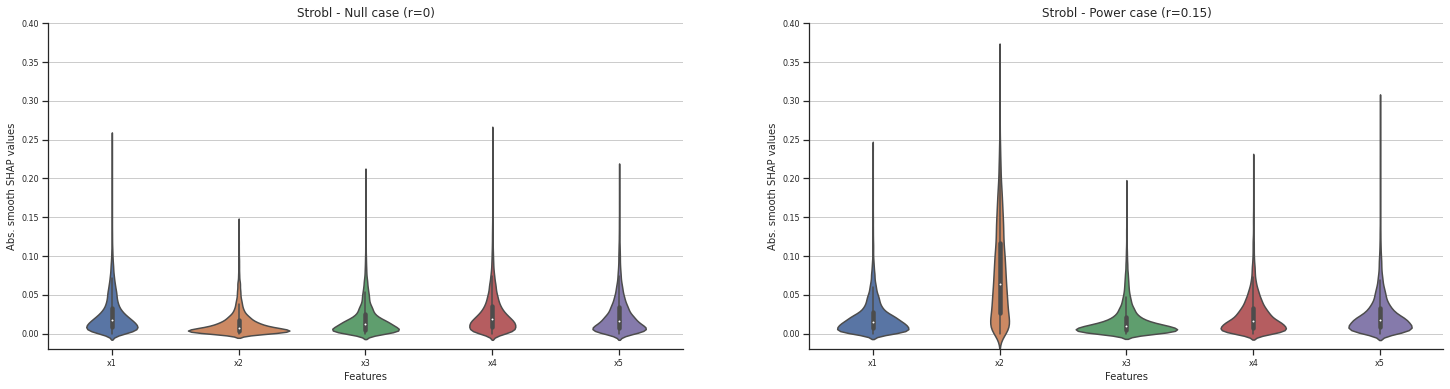

In [148]:
# Check distribution of absolute smooth SHAP values per feature accross the different models
fig, axs = plt.subplots(1,2,figsize=(25,6))

# create dataframes for plotting with seaborn
null_smSHAP_vals_df = pd.DataFrame(np.abs(null_smSHAP_vals_test).reshape(12000,5), columns=["x1","x2","x3","x4","x5"]).melt()
power_smSHAP_vals_df = pd.DataFrame(np.abs(power_smSHAP_vals_test).reshape(12000,5), columns=["x1","x2","x3","x4","x5"]).melt()

n = sns.violinplot(x="variable", y="value", data=null_smSHAP_vals_df, ax=axs[0])
p = sns.violinplot(x="variable", y="value", data=power_smSHAP_vals_df, ax=axs[1])


for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    if i==0:
        ax.set_title(f"Strobl - Null case (r=0)", fontsize="medium")
    else:
        ax.set_title(f"Strobl - Power case (r=0.15)", fontsize="medium")
    ax.set_xlabel("Features", fontsize="small")
    ax.set_ylabel("Abs. smooth SHAP values", fontsize="small")
    ax.grid(axis="y")
    for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(8);

plt.setp(axs, ylim=[-0.02,0.4]); #set global ylim for all suplots

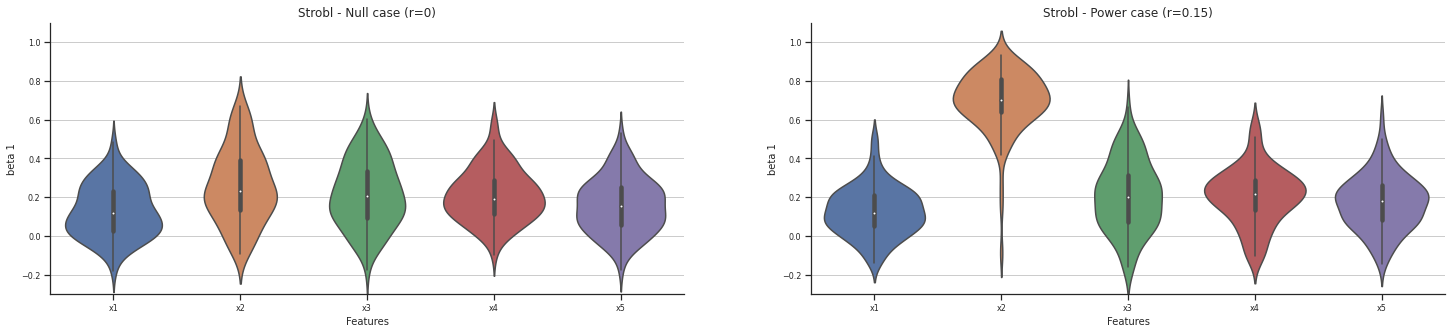

In [149]:
# Check distribution of smooth SHAP coefficients per feature accross the different models
fig, axs = plt.subplots(1,2,figsize=(25,5))

# create dataframes for plotting with seaborn
null_smSHAP_coefs_df = pd.DataFrame(null_smSHAP_coefs_test, columns=["x1","x2","x3","x4","x5"]).melt()
power_smSHAP_coefs_df = pd.DataFrame(power_smSHAP_coefs_test, columns=["x1","x2","x3","x4","x5"]).melt()

n = sns.violinplot(x="variable", y="value", data=null_smSHAP_coefs_df, ax=axs[0])
p = sns.violinplot(x="variable", y="value", data=power_smSHAP_coefs_df, ax=axs[1])


for i, ax in enumerate(fig.axes):
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 0)
    if i==0:
        ax.set_title(f"Strobl - Null case (r=0)", fontsize="medium")
    else:
        ax.set_title(f"Strobl - Power case (r=0.15)", fontsize="medium")
    ax.set_xlabel("Features", fontsize="small")
    ax.set_ylabel("beta 1", fontsize="small")
    ax.grid(axis="y")
    for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(8);
    
plt.setp(axs, ylim=[-0.3,1.1]); #set global ylim for all suplots
